# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [27]:
train_transforms = A.Compose([
    #A.Resize(32, 32),
    A.ShiftScaleRotate(shift_limit = 0.05, scale_limit = 0.05, rotate_limit = 15,p=0.4),
    A.HorizontalFlip(),
    A.ColorJitter (brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16, fill_value=0, mask_fill_value=None, always_apply=False, p=0.3),
    A.Normalize (mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
    ToTensorV2()
])

# Test Phase transformations
test_transforms = A.Compose([
                             ToTensorV2(),
                             A.Normalize (mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
                                       ])

test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                       ])

def apply_transform_train(image):
    return train_transforms(image=np.array(image))

def apply_transform_test(image):
    return test_transforms(image=np.array(image))

# Dataset and Creating Train/Test Split

In [28]:
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=apply_transform_train)
test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [29]:
SEED = 2

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data,**args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **args)

CUDA Available? True


In [30]:
# Shape of the train data
print (train_data.data.shape)
# Shape of the test data
print (test_data.data.shape)

# Number of categories in the data
print (len(train_data.classes))

(50000, 32, 32, 3)
(10000, 32, 32, 3)
10


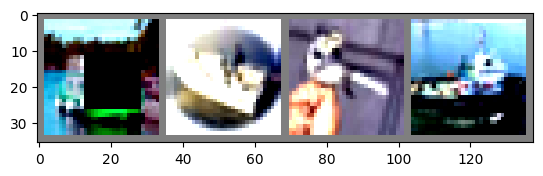

ship  ship  bird  ship 


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images['image'][:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [32]:
dropout_value = 0.1
class Model_CFAR(nn.Module):
    def __init__(self):
        super(Model_CFAR, self).__init__()

        # *******************************Conv Block 1*************************
        # Block1-Layer1
        self.convblk1_ly1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value))

        # Block1-Layer2
        self.convblk1_ly2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=3,  bias=False,dilation=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value))

        # Block1 - TB
        self.convblk1_tb = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=0,stride=2, bias=False),
            nn.ReLU())
        # ****************************Conv Block 2****************************
        # Block 2 - Layer1
        self.convblk2_ly1 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value))

         #Block 2- Layer2
        self.convblk2_ly2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=2, bias=False,dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value))

        # Block 2 - TB
        self.convblk2_tb = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=0,stride=2, bias=False),
            nn.ReLU())
        # ****************************Conv Block 3****************************
        # Block 3 - Layer 1

        self.convblk3_ly1 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value))

        #Block 3 - Layer 2
        self.convblk3_ly2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=2, bias=False,dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value))

        # Block 3- TB
        self.convblk3_tb = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=20, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=1,stride=2, bias=False),
            nn.ReLU())
        # ****************************Conv Block 4****************************
        # Block 4 - Layer 1

        self.convblk4_ly1 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value))

        #Block 4 - Layer 2
        self.convblk4_ly2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=2, bias=False,dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value))

        # Block 4- Layer 3
        self.convblk4_ly3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(3, 3), padding=0,stride=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(48))
        #****************************Output Block*************************
        # GAP Layer
        self.gap = nn.AdaptiveAvgPool2d(1)

       # FC Layer
        self.fc = nn.Linear(48, 10,bias=False)

    def forward(self, x):
        x = self.convblk1_ly1(x)
        x = x+self.convblk1_ly2(x)
        x = self.convblk1_tb(x)
        x = self.convblk2_ly1(x)
        x = x+self.convblk2_ly2(x)
        x = self.convblk2_tb(x)
        x = self.convblk3_ly1(x)
        x = x+self.convblk3_ly2(x)
        x = self.convblk3_tb(x)
        x = self.convblk4_ly1(x)
        x = x+self.convblk4_ly2(x)
        x = self.convblk4_ly3(x)
        x = self.gap(x)
        x = x.view(-1, 1*1*48)
        x = self.fc(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [33]:
x = torch.randn(1,64,32,32)
model=Model_CFAR()
for layer in model.convblk1_ly2:
  x = layer(x)
  print (layer)
  print(x.size())

Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3), bias=False)
torch.Size([1, 64, 32, 32])
ReLU()
torch.Size([1, 64, 32, 32])
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([1, 64, 32, 32])
Dropout(p=0.1, inplace=False)
torch.Size([1, 64, 32, 32])


In [34]:
# Model Summary
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_CFAR().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,728
              ReLU-2           [-1, 64, 30, 30]               0
       BatchNorm2d-3           [-1, 64, 30, 30]             128
           Dropout-4           [-1, 64, 30, 30]               0
            Conv2d-5           [-1, 64, 30, 30]          36,864
              ReLU-6           [-1, 64, 30, 30]               0
       BatchNorm2d-7           [-1, 64, 30, 30]             128
           Dropout-8           [-1, 64, 30, 30]               0
            Conv2d-9           [-1, 20, 30, 30]           1,280
           Conv2d-10           [-1, 20, 14, 14]           3,600
             ReLU-11           [-1, 20, 14, 14]               0
           Conv2d-12           [-1, 64, 12, 12]          11,520
             ReLU-13           [-1, 64, 12, 12]               0
      BatchNorm2d-14           [-1

In [35]:
# Training And Testing

In [36]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data_aug, target = data['image'].to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data_aug)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data_aug)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss


In [37]:
from torch.optim.lr_scheduler import StepLR
model =  Model_CFAR().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.6920554637908936 Batch_id=390 Accuracy=32.09: 100%|██████████| 391/391 [00:38<00:00, 10.21it/s]



Test set: Average loss: 1.4869, Accuracy: 4511/10000 (45.11%)

EPOCH: 1


Loss=1.506892204284668 Batch_id=390 Accuracy=42.76: 100%|██████████| 391/391 [00:29<00:00, 13.04it/s]



Test set: Average loss: 1.3672, Accuracy: 4951/10000 (49.51%)

EPOCH: 2


Loss=1.430444359779358 Batch_id=390 Accuracy=47.69: 100%|██████████| 391/391 [00:28<00:00, 13.52it/s]



Test set: Average loss: 1.2617, Accuracy: 5396/10000 (53.96%)

EPOCH: 3


Loss=1.3354305028915405 Batch_id=390 Accuracy=51.48: 100%|██████████| 391/391 [00:30<00:00, 12.87it/s]



Test set: Average loss: 1.1190, Accuracy: 5970/10000 (59.70%)

EPOCH: 4


Loss=1.336233139038086 Batch_id=390 Accuracy=54.41: 100%|██████████| 391/391 [00:28<00:00, 13.73it/s]



Test set: Average loss: 1.0766, Accuracy: 6170/10000 (61.70%)

EPOCH: 5


Loss=1.2368556261062622 Batch_id=390 Accuracy=56.83: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s]



Test set: Average loss: 1.0989, Accuracy: 6134/10000 (61.34%)

EPOCH: 6


Loss=1.259250521659851 Batch_id=390 Accuracy=59.16: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]



Test set: Average loss: 0.9266, Accuracy: 6740/10000 (67.40%)

EPOCH: 7


Loss=1.2664802074432373 Batch_id=390 Accuracy=60.84: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]



Test set: Average loss: 0.9028, Accuracy: 6850/10000 (68.50%)

EPOCH: 8


Loss=0.9217222929000854 Batch_id=390 Accuracy=62.45: 100%|██████████| 391/391 [00:26<00:00, 14.91it/s]



Test set: Average loss: 0.8750, Accuracy: 6926/10000 (69.26%)

EPOCH: 9


Loss=0.950783908367157 Batch_id=390 Accuracy=63.73: 100%|██████████| 391/391 [00:27<00:00, 14.32it/s]



Test set: Average loss: 0.8368, Accuracy: 7059/10000 (70.59%)

EPOCH: 10


Loss=1.1343295574188232 Batch_id=390 Accuracy=65.14: 100%|██████████| 391/391 [00:28<00:00, 13.81it/s]



Test set: Average loss: 0.7701, Accuracy: 7288/10000 (72.88%)

EPOCH: 11


Loss=0.9319857358932495 Batch_id=390 Accuracy=66.05: 100%|██████████| 391/391 [00:28<00:00, 13.67it/s]



Test set: Average loss: 0.7876, Accuracy: 7273/10000 (72.73%)

EPOCH: 12


Loss=0.9371014833450317 Batch_id=390 Accuracy=67.06: 100%|██████████| 391/391 [00:27<00:00, 14.21it/s]



Test set: Average loss: 0.7636, Accuracy: 7371/10000 (73.71%)

EPOCH: 13


Loss=0.6302847266197205 Batch_id=390 Accuracy=68.06: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s]



Test set: Average loss: 0.7386, Accuracy: 7406/10000 (74.06%)

EPOCH: 14


Loss=0.9584828615188599 Batch_id=390 Accuracy=68.54: 100%|██████████| 391/391 [00:27<00:00, 14.12it/s]



Test set: Average loss: 0.7351, Accuracy: 7432/10000 (74.32%)

EPOCH: 15


Loss=0.7785202860832214 Batch_id=390 Accuracy=69.20: 100%|██████████| 391/391 [00:28<00:00, 13.71it/s]



Test set: Average loss: 0.6854, Accuracy: 7620/10000 (76.20%)

EPOCH: 16


Loss=1.045302152633667 Batch_id=390 Accuracy=70.12: 100%|██████████| 391/391 [00:29<00:00, 13.39it/s]



Test set: Average loss: 0.6766, Accuracy: 7670/10000 (76.70%)

EPOCH: 17


Loss=0.9212864637374878 Batch_id=390 Accuracy=70.48: 100%|██████████| 391/391 [00:27<00:00, 14.13it/s]



Test set: Average loss: 0.7058, Accuracy: 7512/10000 (75.12%)

EPOCH: 18


Loss=1.0360780954360962 Batch_id=390 Accuracy=71.71: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s]



Test set: Average loss: 0.7125, Accuracy: 7566/10000 (75.66%)

EPOCH: 19


Loss=0.897540271282196 Batch_id=390 Accuracy=71.53: 100%|██████████| 391/391 [00:26<00:00, 14.81it/s]



Test set: Average loss: 0.6346, Accuracy: 7786/10000 (77.86%)

EPOCH: 20


Loss=0.7317417860031128 Batch_id=390 Accuracy=73.81: 100%|██████████| 391/391 [00:26<00:00, 15.04it/s]



Test set: Average loss: 0.5861, Accuracy: 7981/10000 (79.81%)

EPOCH: 21


Loss=0.8856317400932312 Batch_id=390 Accuracy=74.69: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s]



Test set: Average loss: 0.5750, Accuracy: 8015/10000 (80.15%)

EPOCH: 22


Loss=0.8812839388847351 Batch_id=390 Accuracy=75.04: 100%|██████████| 391/391 [00:25<00:00, 15.24it/s]



Test set: Average loss: 0.5744, Accuracy: 8027/10000 (80.27%)

EPOCH: 23


Loss=0.4885329306125641 Batch_id=390 Accuracy=75.00: 100%|██████████| 391/391 [00:25<00:00, 15.54it/s]



Test set: Average loss: 0.5708, Accuracy: 8044/10000 (80.44%)

EPOCH: 24


Loss=0.6977364420890808 Batch_id=390 Accuracy=75.13: 100%|██████████| 391/391 [00:25<00:00, 15.16it/s]



Test set: Average loss: 0.5638, Accuracy: 8082/10000 (80.82%)

EPOCH: 25


Loss=0.6586285829544067 Batch_id=390 Accuracy=75.28: 100%|██████████| 391/391 [00:26<00:00, 14.55it/s]



Test set: Average loss: 0.5628, Accuracy: 8070/10000 (80.70%)

EPOCH: 26


Loss=0.710759699344635 Batch_id=390 Accuracy=75.67: 100%|██████████| 391/391 [00:25<00:00, 15.34it/s]



Test set: Average loss: 0.5583, Accuracy: 8095/10000 (80.95%)

EPOCH: 27


Loss=0.7530580163002014 Batch_id=390 Accuracy=75.65: 100%|██████████| 391/391 [00:25<00:00, 15.12it/s]



Test set: Average loss: 0.5590, Accuracy: 8073/10000 (80.73%)

EPOCH: 28


Loss=0.7768410444259644 Batch_id=390 Accuracy=75.59: 100%|██████████| 391/391 [00:26<00:00, 14.85it/s]



Test set: Average loss: 0.5568, Accuracy: 8084/10000 (80.84%)

EPOCH: 29


Loss=0.5932052135467529 Batch_id=390 Accuracy=75.52: 100%|██████████| 391/391 [00:25<00:00, 15.18it/s]



Test set: Average loss: 0.5590, Accuracy: 8083/10000 (80.83%)

EPOCH: 30


Loss=0.7248592972755432 Batch_id=390 Accuracy=75.68: 100%|██████████| 391/391 [00:25<00:00, 15.20it/s]



Test set: Average loss: 0.5566, Accuracy: 8090/10000 (80.90%)

EPOCH: 31


Loss=0.6748847961425781 Batch_id=390 Accuracy=76.28: 100%|██████████| 391/391 [00:25<00:00, 15.14it/s]



Test set: Average loss: 0.5482, Accuracy: 8082/10000 (80.82%)

EPOCH: 32


Loss=0.8383787274360657 Batch_id=390 Accuracy=76.23: 100%|██████████| 391/391 [00:26<00:00, 14.97it/s]



Test set: Average loss: 0.5481, Accuracy: 8111/10000 (81.11%)

EPOCH: 33


Loss=0.6877790093421936 Batch_id=390 Accuracy=76.01: 100%|██████████| 391/391 [00:26<00:00, 15.00it/s]



Test set: Average loss: 0.5488, Accuracy: 8111/10000 (81.11%)

EPOCH: 34


Loss=0.7319894433021545 Batch_id=390 Accuracy=76.25: 100%|██████████| 391/391 [00:26<00:00, 14.54it/s]



Test set: Average loss: 0.5498, Accuracy: 8101/10000 (81.01%)

EPOCH: 35


Loss=0.81739741563797 Batch_id=390 Accuracy=76.51: 100%|██████████| 391/391 [00:26<00:00, 14.72it/s]



Test set: Average loss: 0.5487, Accuracy: 8111/10000 (81.11%)

EPOCH: 36


Loss=0.6639783978462219 Batch_id=390 Accuracy=76.45: 100%|██████████| 391/391 [00:27<00:00, 14.45it/s]



Test set: Average loss: 0.5447, Accuracy: 8129/10000 (81.29%)

EPOCH: 37


Loss=0.7978916168212891 Batch_id=390 Accuracy=76.37: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]



Test set: Average loss: 0.5457, Accuracy: 8144/10000 (81.44%)

EPOCH: 38


Loss=0.5832236409187317 Batch_id=390 Accuracy=76.58: 100%|██████████| 391/391 [00:27<00:00, 14.22it/s]



Test set: Average loss: 0.5398, Accuracy: 8148/10000 (81.48%)

EPOCH: 39


Loss=0.6267361640930176 Batch_id=390 Accuracy=76.47: 100%|██████████| 391/391 [00:26<00:00, 14.83it/s]



Test set: Average loss: 0.5453, Accuracy: 8140/10000 (81.40%)

EPOCH: 40


Loss=0.5400607585906982 Batch_id=390 Accuracy=76.87: 100%|██████████| 391/391 [00:26<00:00, 14.72it/s]



Test set: Average loss: 0.5358, Accuracy: 8157/10000 (81.57%)

EPOCH: 41


Loss=0.5935578346252441 Batch_id=390 Accuracy=76.90: 100%|██████████| 391/391 [00:26<00:00, 14.75it/s]



Test set: Average loss: 0.5365, Accuracy: 8176/10000 (81.76%)

EPOCH: 42


Loss=0.7148352861404419 Batch_id=390 Accuracy=76.96: 100%|██████████| 391/391 [00:26<00:00, 14.57it/s]



Test set: Average loss: 0.5333, Accuracy: 8184/10000 (81.84%)

EPOCH: 43


Loss=0.7254691123962402 Batch_id=390 Accuracy=77.02: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s]



Test set: Average loss: 0.5336, Accuracy: 8191/10000 (81.91%)

EPOCH: 44


Loss=0.8565025329589844 Batch_id=390 Accuracy=76.92: 100%|██████████| 391/391 [00:27<00:00, 14.01it/s]



Test set: Average loss: 0.5332, Accuracy: 8193/10000 (81.93%)

EPOCH: 45


Loss=0.780258297920227 Batch_id=390 Accuracy=76.65: 100%|██████████| 391/391 [00:26<00:00, 14.68it/s]



Test set: Average loss: 0.5364, Accuracy: 8179/10000 (81.79%)

EPOCH: 46


Loss=0.6380599737167358 Batch_id=390 Accuracy=76.83: 100%|██████████| 391/391 [00:26<00:00, 14.58it/s]



Test set: Average loss: 0.5346, Accuracy: 8157/10000 (81.57%)

EPOCH: 47


Loss=0.7101469039916992 Batch_id=390 Accuracy=77.00: 100%|██████████| 391/391 [00:26<00:00, 14.61it/s]



Test set: Average loss: 0.5313, Accuracy: 8169/10000 (81.69%)

EPOCH: 48


Loss=0.5076721906661987 Batch_id=390 Accuracy=77.19: 100%|██████████| 391/391 [00:26<00:00, 14.53it/s]



Test set: Average loss: 0.5330, Accuracy: 8183/10000 (81.83%)

EPOCH: 49


Loss=0.784282386302948 Batch_id=390 Accuracy=77.15: 100%|██████████| 391/391 [00:26<00:00, 14.59it/s]



Test set: Average loss: 0.5335, Accuracy: 8167/10000 (81.67%)



In [22]:

# Wrong predictions
cnt=0
import random
data, target = next(iter(test_loader))
data, target = data.to(device), target.to(device)
output = model(data)
pred = output.argmax(dim=1, keepdim=True)
img_lst=[]
cat_lst=[]
x_lst=[]
for i in range(0,127):
  x = random.randint(0,127)

  if pred[x].item()!=target[x].item():
    img=data[x].cpu().numpy().T
    img_lst.append(img)
    cat=[value for key,value in enumerate(train_data.class_to_idx) if key!=target[x].item()][0]
    cat_lst.append(cat)
    x_lst.append(x)
    cnt+=1
  if cnt>9:
    break

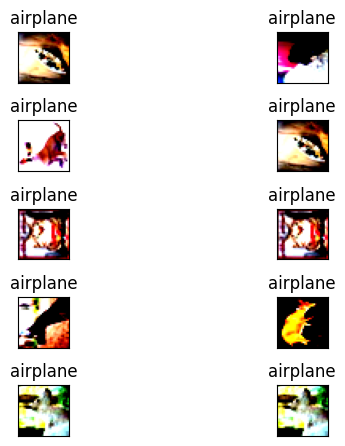

In [23]:
for i in range(10):
  plt.subplot(5,2,i+1)
  plt.tight_layout()
  plt.imshow(img_lst[i])
  plt.title(cat_lst[i])
  plt.xticks([])
  plt.yticks([])